# QSVM aplicado a um database de manutenção

Elaborado por:
- Equipe Qast - Beer Quantum Challenge (Ambev+QB) 2021

Nos notebooks anteriores:

- Estudamos "casos extremos" do uso do QSVM comparado ao SVM

Porém, os dados utilizados eram sintéticos

Neste notebook:

- Vamos utilizar o QSVM com um database de manutenção preventiva, retirado de https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

### 1) Importar bilbiotecas 

In [145]:
#general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#qiskit imports
from qiskit import Aer, IBMQ
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap

#scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import sklearn.svm as svm
from sklearn.metrics import accuracy_score
from qiskit_machine_learning.kernels import QuantumKernel

### 2. Carregar dados

In [104]:
df = pd.read_csv('ai4i2020.csv')

df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [109]:
#Somente parte vai ser utilizada, por limitações da simulação. Vamos aproveitar então para construir um database equilibrado
dffailure = df[df['Machine failure'] == 1].sample(100)

dfworking = df[df['Machine failure'] != 1].sample(100)

df = pd.concat([dffailure, dfworking], axis = 0)

df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
4840,4841,L52020,L,303.4,311.9,1298,63.9,59,1,0,1,0,0,0
3528,3529,L50708,L,302.0,310.9,1378,53.1,212,1,0,0,0,1,0
4501,4502,L51681,L,302.5,310.2,1307,54.0,86,1,0,1,0,0,0
4185,4186,L51365,L,302.2,310.6,1348,48.4,161,1,0,1,0,0,0
6678,6679,M21538,M,301.5,310.7,1336,65.6,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3750,3751,L50930,L,302.3,311.1,1589,29.9,141,0,0,0,0,0,0
2276,2277,L49456,L,299.3,308.7,1393,54.2,80,0,0,0,0,0,0
5427,5428,L52607,L,302.7,312.4,1423,51.9,60,0,0,0,0,0,0
3938,3939,L51118,L,302.5,311.5,1603,32.4,194,0,0,0,0,0,0


### 3. Preparar features

In [110]:
dic = {'L' : -1, 'M' : 0, 'H'  : 1}

df['TypeNum'] = df['Type'].apply(lambda x : dic[x])

In [111]:
features_labels = ['TypeNum', 'Air temperature [K]',
    'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
    'Tool wear [min]']
    
target_label = ['Machine failure']

df = df[features_labels + target_label]

### 4. separar e padronizar dados

In [112]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    df[features_labels], df[target_label], test_size=0.2, random_state=42)

#8000 for training, 2000 for testing

In [114]:
# Standardize
ss = StandardScaler()
Xtrain = ss.fit_transform(Xtrain)
Xtest = ss.transform(Xtest)

In [229]:
#PCA 
feature_dimension = 4
pca = PCA(n_components=feature_dimension, svd_solver='full')

pca.fit(np.concatenate([Xtrain, Xtest], axis = 0))

Xtrain_pca = pca.transform(Xtrain)
Xtest_pca = pca.transform(Xtest)


# 5 Quantum SVM - simulação

In [230]:
backend = Aer.get_backend('statevector_simulator')
#feature_map = PauliFeatureMap(feature_dimension, reps = 1, paulis=['Y'])
feature_map = ZFeatureMap(feature_dimension=feature_dimension, reps = 2)

In [231]:
QKernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

Exemplo do circuito paramétrico escolhido

/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


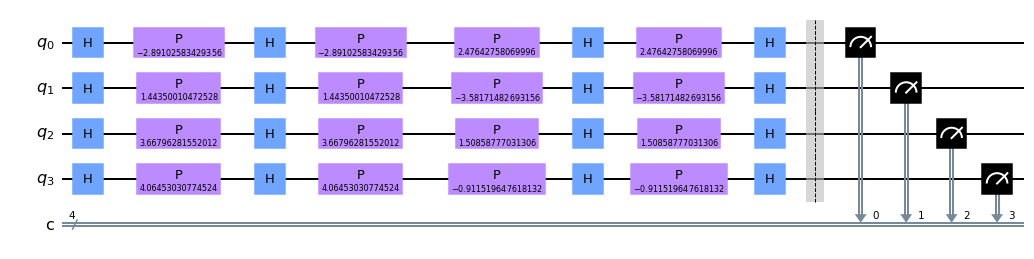

In [232]:
QKernel.construct_circuit(Xtrain_pca[0], Xtrain_pca[1]).decompose().decompose().draw(output= 'mpl')

In [233]:
matrix_train = QKernel.evaluate(x_vec=Xtrain_pca)
matrix_test = QKernel.evaluate(x_vec=Xtest_pca, y_vec=Xtrain_pca)

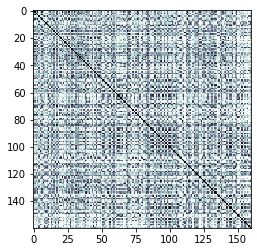

In [226]:
#matrix kernel
img = plt.imshow(np.asmatrix(matrix_train), interpolation = 'nearest', origin='upper', cmap = 'bone_r')

In [227]:
qsvc = svm.SVC(kernel='precomputed')
qsvc.fit(matrix_train, ytrain)
quantum_score = qsvc.score(matrix_test, ytest)

/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [228]:
quantum_score

0.575

A performance do qsvm é razoável no espaço de teste! Como usamos um circuito simples (pequeno e sem necessidade de CNOTs), vamos tentar executar o qsvm usando um dispositivo quântico NISQ real

# 6 Quantum SVM - Computador quântico real

In [99]:
provider = IBMQ.load_account()
backend =provider.get_backend('ibmq_quito')

ibmqfactory.load_account:WARNING:2021-11-19 22:10:33,970: Credentials are already in use. The existing account in the session will be replaced.


um PCA vai ser necessário primeiro (somente 5 qubits disponíveis)

In [ ]:
QKernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

backend = IBMQ.get_backend('ibmq_quito')

In [143]:
csvc = svm.SVC(kernel='rbf')
csvc.fit(Xtrain, ytrain)
c_score = csvc.score(Xtest, ytest)
c_score


/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.85